This module will dive into human-in-the-loop, which builds on memory and allows users to interact directly with graphs in various ways.

To set the stage for human-in-the-loop, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

# **Streaming**
LangGraph is built with first class support for streaming.

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution.

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file with UTF-8 encoding
load_dotenv(encoding='utf-8')

# Get the API key from environment
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

Note that we use RunnableConfig with call_model to enable token-wise streaming. This is only needed with python < 3.11. We include in case you are running this notebook in CoLab, which will use python 3.x.

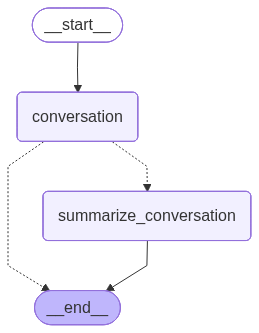

In [6]:
from IPython.display import Image, display
from typing import Literal

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

    # Determine whether to end or summarize the conversation
def should_continue(state: State)-> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

    # Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

# **Streaming full state**
Now, let's talk about ways to stream our graph state.

.stream and .astream are sync and async methods for streaming back results.

LangGraph supports a few different streaming modes for graph state.

**values:** This streams the full state of the graph after each node is called.

**updates:** This streams updates to the state of the graph after each node is called.

Let's look at stream_mode="updates".

Because we stream with updates, we only see updates to the state after node in the graph is run.

Each chunk is a dict with node_name as the key and the updated state as the value.

In [7]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello, Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 11, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-CmoauNo0ePgcXkdDOVFQOtA16RQTs', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b1eea-cccd-7ef2-a0f9-336b97c9ac8f-0', usage_metadata={'input_tokens': 11, 'output_tokens': 11, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


Let's now just print the state update.

In [8]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi again, Lance! How can I help you today?


Now, we can see stream_mode="values".

This is the full state of the graph after the conversation node is called.


In [9]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
---------------------------------------------------------------------------


# **Streaming tokens**
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

event: This is the type of event that is being emitted.
name: This is the name of event.
data: This is the data associated with the event.
metadata: Containslanggraph_node, the node emitting the event.
Let's have a look.

In [16]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

The central point is that tokens from chat models within your graph have the on_chat_model_stream type.

We can use event['metadata']['langgraph_node'] to select the node to stream from.

And we can use event['data'] to get the actual data for each event, which in this case is an AIMessageChunk.

In [17]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b1f38-1921-7f72-9e90-7a15e7ae2928')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b1f38-1921-7f72-9e90-7a15e7ae2928')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b1f38-1921-7f72-9e90-7a15e7ae2928')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b1f38-1921-7f72-9e90-7a15e7ae2928')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b1f38-1921-7f72-9e90-7a15e7ae2928')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b1f38-1921-7f72-9e90-7a15e7ae2928')}
{'chunk': AIMessageChunk(c

As you see above, just use the chunk key to get the AIMessageChunk.

In [18]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| stor|ied| franchise| in| the| National| Football| League| (|NFL|),| known| for| their| rich| history| and| success| on| the| field|.| Here's| an| overview| of| the| team|:

|###| Overview|

|-| **|Founded|**|:| |194|6|
|-| **|Location|**|:| San| Francisco| Bay| Area|,| California|
|-| **|St|adium|**|:| Levi|'s| Stadium| in| Santa| Clara|,| California|
|-| **|Team| Colors|**|:| Red|,| Gold|,| and| White|
|-| **|Masc|ot|**|:| S|ourd|ough| Sam|

|###| Historical| Success|

|-| **|Super| Bowl| Championships|**|:| The| |49|ers| have| won| five| Super| Bowl| titles|,| in| the| |198|1|,| |198|4|,| |198|8|,| |198|9|,| and| |199|4| seasons|.| This| success| places| them| among| the| most| successful| teams| in| NFL| history|.
|-| **|Conference| Championships|**|:| They| have| won| multiple| NFC| Championships|,| further| establishing| their| dominance|,| particularly| during| the| |198|0|s| and| |199|0|s|.
|-| **|Division| Titles|**|:| The| team| has| won|